# Predicting The Stock Market with Trump's Tweets
- James M. Irving
- james.irving.phd@gmail.com
- Updated 10/25/20

In [55]:
## Control Downloading fresh data
DOWNLOAD_DATA = False

> **Note to my students: You are not allowed to use any propriety functions from this notebook in your projects.**

In [56]:
## Set random seeds for reproducibility
import numpy as np
np.random.seed(321)

import tensorflow as tf
tf.random.set_seed(321)

# OBTAIN

### DATA SOURCES:

* **All Donald Trump tweets from 12/01/2016 (pre-inaugaration day) ~~to end of 08/23/2018~~**
    *          ~~Extracted from http://www.trumptwitterarchive.com/~~
    - Trump Twitter Archive 2.0 (now with API endpoint)
    - https://www.thetrumparchive.com/

* **Minute-resolution data for the S&P500 covering the same time period.**
    *         IVE S&P500 Index from - http://www.kibot.com/free_historical_data.aspx
    - (***Aggregate 1 min bid-ask data link***)
        - http://api.kibot.com/?action=history&symbol=IVE&interval=tickbidask1&bp=1&user=guest
    
    
* NOTE: Both sources required manual extraction and both 1-min historical stock data and batch-historical-tweet data are difficult to obtain without paying \\$150-\\$2000 monthly developer memberships. 

In [57]:
import os,sys,glob,time
sys.path.append('py_files/')

## IMPORT CUSTOM CAPSTONE FUNCTIONS
import functions_combined_BEST as ji
import functions_io as io

## Import data downloading packages
import datetime as dt
import requests
import pandas as pd
import json

In [58]:
# !pip install -U fsds
from fsds.imports import *

In [59]:
def download_stock_data(fpath='data/ive_minute_tick_bidask_API.csv',
                       verbose=True,append_date=True):
    """Downloads up-to-date IVE S&P 500 1-min aggregate data from 
    http://www.kibot.com/free_historical_data.aspx
    
    Args:
        fpath (str): csv filepath to save (Default='data/ive_minute_tick_bidask_API.csv')
        verbose (bool): Display file info (Default=True)
        
    Returns:
        stock_df: DataFrame with correct headers and datetime index"""
    agg_url = 'http://api.kibot.com/?action=history&symbol=IVE&interval=tickbidask1&bp=1&user=guest'
    response = requests.get(agg_url,
                            allow_redirects=True)

    ## Save output to csv file
    with open(fpath,'wb') as file:
        file.write(response.content)
        
        
    ## Load in Stock Data Frame with headers (then save)
    headers = ['Date','Time','BidOpen','BidHigh','BidLow','BidClose','AskOpen','AskHigh','AskLow','AskClose']
    stock_df = pd.read_csv(fpath,names=headers)

# 
    ## Make Combined Date Time column and Drop Origs
    stock_df['datetime'] = pd.to_datetime(stock_df['Date'].astype(str)+' '+stock_df['Time'].astype(str))
    
    if append_date:
        suffix = dt.date.today().strftime('%m-%d-%y')
        fpath = f"{fpath.split('.csv')[0]}_{suffix}.csv"
        
    print(f'Saving as {fpath}')
    stock_df.to_csv(fpath,index=False)
        
    if verbose:
        print('[i] Stock data successfully downloaded and saved as:')
        print(' - ',fpath)
        
    return pd.read_csv(fpath,parse_dates=['datetime'],index_col='datetime')

In [60]:
def download_trump_tweets(fpath='data/trump_tweets.csv',append_date=True,
                          verbose=True,return_data=True):
    """Downloads the most recent data from the trumptwittearchive v2.
    https://drive.google.com/uc?export=download&id=1JZnhB0Nq_2RKtDb-IOnd0XxnD5c7x-nQ
    
    Args:
        fpath (str): filepath for data that ends with .csv
        append_date (bool): Whether to save today's date as part of filename(Default=True)
        verbose (bool): Whether to print the file name (Default=True)
        return_data (bool): Whether to return the data as a df (Default=True)"""
#     url = "https://www.thetrumparchive.com/latest-tweets"
    url="https://drive.google.com/uc?export=download&id=1JZnhB0Nq_2RKtDb-IOnd0XxnD5c7x-nQ"
    response = requests.get(url)
    
    if append_date:
        suffix = "_"+dt.date.today().strftime('%m-%d-%y')
        filepath = f"{fpath.split('.')[0]}{suffix}.{fpath.split('.')[-1]}"
    else:
        filepath=fpath
        
        
    ## Save output to csv file
    with open(filepath,'wb') as file:
        file.write(response.content)  
        
#     with open(filepath,'w') as f:
# #         f.write(response.content)
#         f.write(json.dumps(response.json()))
    
#     if fpath.endswith('.csv'):
#         tweets = pd.read_json(filepath)
#         tweets.to_csv(filepath)
#     else: 
#         tweets = pd.read_json(filepath)
        
    if verbose:
        print('[i] Tweet data successfully downloaded and saved as:')
        print('- ',filepath)
        
    if return_data:

        return pd.read_csv(filepath,index_col=0,parse_dates=['date'])
#tweets#,parse_dates=['created_at'])

In [61]:
## DOWNLOAD THE DATA IF REQUESTED
if DOWNLOAD_DATA:
    print('[i] Downoading data sets...')
    stock_df = download_stock_data()
    tweets = download_trump_tweets()
    
else: 
    ## Or Load in Most Recent Files
    print('[i] Loading most recent data sets...')
    
    ## Check for prx-existing files
    files_glob = glob.glob('data/*.csv')
    stock_files = list(filter(lambda x: 'ive_minute' in x, files_glob))
    tweet_files = list(filter(lambda x: 'tweet' in x, files_glob))


    ## Get Time Files Modified 
    TWEET_FILES = {f:pd.to_datetime(time.ctime(os.path.getmtime(f))) for f in tweet_files}
    STOCK_FILES = {f:pd.to_datetime(time.ctime(os.path.getmtime(f))) for f in stock_files}

    ## Get most recent files using idxmin
    recent_stocks = pd.Series(STOCK_FILES).idxmax()
    recent_tweets = pd.Series(TWEET_FILES).idxmax()
    
    ## Load in the csvs with datetime indices
    tweets = pd.read_csv(recent_tweets,parse_dates=['date'],index_col='date')
    stock_df = pd.read_csv(recent_stocks,parse_dates=['datetime'],index_col='datetime')
    
    ## Sort timeseries
    tweets.sort_index(inplace=True)
    stock_df.sort_index(inplace=True)
    
    
    
## Display Preview of DFs
display(stock_df.head(),tweets.head())

[i] Loading most recent data sets...


,Date,Time,BidOpen,BidHigh,BidLow,BidClose,AskOpen,AskHigh,AskLow,AskClose
datetime,,,,,,,,,,
2009-09-28 09:30:00,09/28/2009,09:30,39.06,39.06,39.06,39.06,39.13,39.13,39.13,39.13
2009-09-28 09:31:00,09/28/2009,09:31,39.10,39.10,39.08,39.09,39.11,39.11,39.10,39.11
2009-09-28 09:32:00,09/28/2009,09:32,39.11,39.15,39.11,39.15,39.12,39.16,39.12,39.16
2009-09-28 09:33:00,09/28/2009,09:33,39.14,39.14,39.14,39.14,39.15,39.16,39.15,39.15
2009-09-28 09:34:00,09/28/2009,09:34,39.14,39.14,39.12,39.12,39.15,39.15,39.14,39.14


,date-corrected,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date,,,,,,,,,,,,,,,,,
2009-09-29 15:28:23,2009-09-29 11:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73,39.67,-0.06,no change,no change,no change,no change
2009-10-05 14:37:38,2009-10-05 10:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56,38.57,0.01,no change,no change,no change,no change
2009-10-14 14:13:17,2009-10-14 10:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46,40.51,0.05,no change,no change,no change,no change
2009-10-27 15:31:48,2009-10-27 11:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26,39.19,-0.07,no change,no change,no change,no change
2009-11-02 14:57:56,2009-11-02 10:57:56,5364614040,"--Work has begun, ahead of schedule, to build ...",f,f,Twitter Web Client,12,12,2009-11-02 11:58:00,2009-11-02 10:58:00,38.49,38.50,0.01,no change,no change,no change,no change


In [62]:
stock_df.shape, tweets.shape

((917804, 10), (8721, 17))

# Creating the Target

In [63]:
stock_df = stock_df[['BidClose']].sort_index()#.reset_index()#.asfreq('T')
stock_df

,BidClose
datetime,
2009-09-28 09:30:00,39.06
2009-09-28 09:31:00,39.09
2009-09-28 09:32:00,39.15
2009-09-28 09:33:00,39.14
2009-09-28 09:34:00,39.12
...,...
2020-11-11 15:58:00,122.12
2020-11-11 15:59:00,122.09
2020-11-11 16:00:00,122.17


## Stock Preprocessing

In [64]:
# ## Remove rare 0-values
stock_df = stock_df[~(stock_df==0).any(axis=1)]
stock_df.shape

(917787, 1)

<AxesSubplot:xlabel='datetime'>

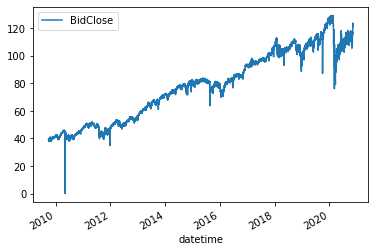

In [65]:
stock_df.plot()

In [66]:
## Now, convert stock_df to minute frequency
stock_df = stock_df.asfreq('T')
stock_df.index

DatetimeIndex(['2009-09-28 09:30:00', '2009-09-28 09:31:00',
               '2009-09-28 09:32:00', '2009-09-28 09:33:00',
               '2009-09-28 09:34:00', '2009-09-28 09:35:00',
               '2009-09-28 09:36:00', '2009-09-28 09:37:00',
               '2009-09-28 09:38:00', '2009-09-28 09:39:00',
               ...
               '2020-11-11 18:03:00', '2020-11-11 18:04:00',
               '2020-11-11 18:05:00', '2020-11-11 18:06:00',
               '2020-11-11 18:07:00', '2020-11-11 18:08:00',
               '2020-11-11 18:09:00', '2020-11-11 18:10:00',
               '2020-11-11 18:11:00', '2020-11-11 18:12:00'],
              dtype='datetime64[ns]', name='datetime', length=5849803, freq='T')

In [67]:
stock_df.isna().sum()

BidClose    4932016
dtype: int64

In [68]:
# (stock_df==0).sum()

## Tweet Processing

In [69]:
display(tweets.head(),tweets.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8721 entries, 2009-09-29 15:28:23 to 2020-10-23 18:45:47
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date-corrected      8721 non-null   object 
 1   id                  8721 non-null   int64  
 2   text                8721 non-null   object 
 3   isRetweet           8721 non-null   object 
 4   isDeleted           8721 non-null   object 
 5   device              8721 non-null   object 
 6   favorites           8721 non-null   int64  
 7   retweets            8721 non-null   int64  
 8   stock_time          8721 non-null   object 
 9   tweet_minute        8721 non-null   object 
 10  tweet_minute_price  8721 non-null   float64
 11  stock_time_price    8721 non-null   float64
 12  delta_price         8721 non-null   float64
 13  delta_bins          8721 non-null   object 
 14  price_bins          8721 non-null   object 
 15  target             

,date-corrected,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date,,,,,,,,,,,,,,,,,
2009-09-29 15:28:23,2009-09-29 11:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73,39.67,-0.06,no change,no change,no change,no change
2009-10-05 14:37:38,2009-10-05 10:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56,38.57,0.01,no change,no change,no change,no change
2009-10-14 14:13:17,2009-10-14 10:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46,40.51,0.05,no change,no change,no change,no change
2009-10-27 15:31:48,2009-10-27 11:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26,39.19,-0.07,no change,no change,no change,no change
2009-11-02 14:57:56,2009-11-02 10:57:56,5364614040,"--Work has begun, ahead of schedule, to build ...",f,f,Twitter Web Client,12,12,2009-11-02 11:58:00,2009-11-02 10:58:00,38.49,38.50,0.01,no change,no change,no change,no change


None

### Finding the Matching Tweets/Stock Data

In [70]:
tweets.reset_index()['date'].dt.ceil('T')

0      2009-09-29 15:29:00
1      2009-10-05 14:38:00
2      2009-10-14 14:14:00
3      2009-10-27 15:32:00
4      2009-11-02 14:58:00
               ...        
8716   2020-10-23 16:56:00
8717   2020-10-23 17:10:00
8718   2020-10-23 17:55:00
8719   2020-10-23 18:41:00
8720   2020-10-23 18:46:00
Name: date, Length: 8721, dtype: datetime64[ns]

In [71]:
import math


In [72]:
tweets[tweets['text'].str.contains('Sleepy Joe')]#.tail(20)]

,date-corrected,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date,,,,,,,,,,,,,,,,,
2019-04-29 14:51:03,2019-04-29 10:51:03,1122875949933051904,Sleepy Joe Biden is having his first rally in ...,f,f,Twitter for iPhone,67529,14946,2019-04-29 11:52:00,2019-04-29 10:52:00,112.75,112.75,0.00,no change,no change,no change,no change
2019-05-20 14:08:04,2019-05-20 10:08:04,1130475280164896768,Looks like Bernie Sanders is history. Sleepy J...,f,f,Twitter for iPhone,99247,20847,2019-05-20 11:09:00,2019-05-20 10:09:00,108.52,108.44,-0.08,no change,no change,no change,no change
2019-07-11 15:52:19,2019-07-11 11:52:19,1149345681829744647,"...years, or maybe 10 or 14 (just kidding), th...",f,f,Twitter for iPhone,42586,8771,2019-07-11 12:53:00,2019-07-11 11:53:00,114.41,114.39,-0.02,no change,no change,no change,no change
2019-07-26 13:58:15,2019-07-26 09:58:15,1154752797637783552,.@FoxNews is at it again. So different from wh...,f,f,Twitter for iPhone,77244,14269,2019-07-26 10:59:00,2019-07-26 09:59:00,115.41,115.54,0.13,increase,no change,no change,increase
2019-10-09 17:55:33,2019-10-09 13:55:33,1181991604493656064,"So pathetic to see Sleepy Joe Biden, who with ...",f,f,Twitter for iPhone,96621,22630,2019-10-09 14:56:00,2019-10-09 13:56:00,113.29,113.42,0.13,no change,no change,no change,no change
2019-10-09 18:12:21,2019-10-09 14:12:21,1181995834369544198,Sleepy Joe Biden! https://t.co/oZtytImXqq,f,f,Twitter for iPhone,73068,24490,2019-10-09 15:13:00,2019-10-09 14:13:00,113.26,113.53,0.27,increase,increase,increase,increase
2019-11-07 14:51:38,2019-11-07 10:51:38,1192454569936216065,“What did Hunter Biden do for the money?” @Sen...,f,f,Twitter for iPhone,50654,13446,2019-11-07 11:52:00,2019-11-07 10:52:00,122.51,122.36,-0.15,decrease,no change,no change,decrease
2019-12-20 18:18:27,2019-12-20 14:18:27,1208089293308211202,"I guess the magazine, “Christianity Today,” is...",f,f,Twitter for iPhone,106200,21743,2019-12-20 15:19:00,2019-12-20 14:19:00,127.17,127.24,0.07,no change,no change,no change,no change
2020-03-04 15:40:01,2020-03-04 11:40:01,1235228511314620416,Mini Mike Bloomberg just “quit” the race for P...,f,f,Twitter for iPhone,136024,25323,2020-03-04 12:41:00,2020-03-04 11:41:00,115.70,116.15,0.45,increase,increase,increase,increase


In [73]:
## Fixing Tweet Timestamps
## Obama is campaining for us. Tweet
test_ts = '2020-10-22 15:26'
tweets_df_ts = pd.to_datetime(test_ts)
twitter_ts = pd.to_datetime('11:26 AM  Oct 22, 2020')
twitter_ts,tweets_df_ts

(Timestamp('2020-10-22 11:26:00'), Timestamp('2020-10-22 15:26:00'))

In [74]:
tweets.loc[test_ts]

,date-corrected,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date,,,,,,,,,,,,,,,,,
2020-10-22 15:26:26,2020-10-22 11:26:26,1319299079264940039,Obama is campaigning for us. Every time he spe...,f,f,Twitter for iPhone,206025,36232,2020-10-22 12:27:00,2020-10-22 11:27:00,115.93,115.9,-0.03,no change,no change,no change,no change


In [75]:
# tweets[tweets['text'].str.contains('covfefe')]

In [76]:
# tweets[tweets['text'].str.contains('covfefe')]


In [77]:
# ## Second test_ts to verify time delay
# test_ts2 = "2017-05-31 04:06"
# tweets_df_ts2 = pd.to_datetime(test_ts2)#tweets[tweets['text'].str.contains('covfefe')].index[0]

# twitter_ts2 = pd.to_datetime('6:09 AM  May 31, 2017')
# twitter_ts2,tweets_df_ts2

In [78]:
# tweets_df_ts.tz

In [79]:
## save tdelta to use to fix tweet timestamps
tdelta = pd.to_timedelta(tweets_df_ts - twitter_ts,unit='min')
tdelta

Timedelta('0 days 04:00:00')

In [80]:
# ## save tdelta to use to fix tweet timestamps
# tdelta2 = pd.to_timedelta(tweets_df_ts2 - twitter_ts2,unit='min')
# tdelta2

### Making `date-corrected`

### Note: Changing Freq to Daily Due top Timestamp issues with TrumpTwitterArchive

In [81]:
## Making Corrected Date
tweets['date-corrected'] = tweets.index - tdelta
tweets

,date-corrected,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date,,,,,,,,,,,,,,,,,
2009-09-29 15:28:23,2009-09-29 11:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73,39.67,-0.06,no change,no change,no change,no change
2009-10-05 14:37:38,2009-10-05 10:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56,38.57,0.01,no change,no change,no change,no change
2009-10-14 14:13:17,2009-10-14 10:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46,40.51,0.05,no change,no change,no change,no change
2009-10-27 15:31:48,2009-10-27 11:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26,39.19,-0.07,no change,no change,no change,no change
2009-11-02 14:57:56,2009-11-02 10:57:56,5364614040,"--Work has begun, ahead of schedule, to build ...",f,f,Twitter Web Client,12,12,2009-11-02 11:58:00,2009-11-02 10:58:00,38.49,38.50,0.01,no change,no change,no change,no change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-23 16:55:29,2020-10-23 12:55:29,1319683876046934016,HUGE win today for the United States and for p...,f,f,Twitter for iPhone,211044,50959,2020-10-23 13:56:00,2020-10-23 12:56:00,116.30,116.62,0.32,increase,increase,increase,increase
2020-10-23 17:09:21,2020-10-23 13:09:21,1319687368014704642,Today is the LAST DAY to register to VOTE in-p...,f,f,Twitter for iPhone,52213,10785,2020-10-23 14:10:00,2020-10-23 13:10:00,116.40,116.64,0.24,increase,no change,no change,increase
2020-10-23 17:54:01,2020-10-23 13:54:01,1319698607851868160,RT @IvankaTrump: Yesterday @realDonaldTrump gr...,t,f,Twitter for iPhone,0,46485,2020-10-23 14:55:00,2020-10-23 13:55:00,116.59,116.77,0.18,increase,no change,no change,increase


In [82]:
## Make new date-corrected index
tweets = tweets.reset_index(drop=False).set_index('date-corrected')

In [83]:
## Getting first, alst stock_df
first_stock_ts = stock_df.index[0]
last_stock_ts = stock_df.index[-1]
first_stock_ts,last_stock_ts

(Timestamp('2009-09-28 09:30:00', freq='T'),
 Timestamp('2020-11-11 18:12:00', freq='T'))

In [84]:
first_tweet_ts = tweets.index[0]
last_tweet_ts = tweets.index[-1]
first_tweet_ts,last_tweet_ts

(Timestamp('2009-09-29 11:28:23'), Timestamp('2020-10-23 14:45:47'))

In [85]:
## MAKING DF TIME PERIODS MATCH
stock_df = stock_df.loc[first_tweet_ts:]
stock_df

,BidClose
datetime,
2009-09-29 11:29:00,39.73
2009-09-29 11:30:00,39.73
2009-09-29 11:31:00,39.74
2009-09-29 11:32:00,39.72
2009-09-29 11:33:00,39.71
...,...
2020-11-11 18:08:00,NaN
2020-11-11 18:09:00,NaN
2020-11-11 18:10:00,NaN


In [86]:
## Cutting both dfs to match the timespan of the other
tweets = tweets.loc[first_stock_ts:last_stock_ts-pd.to_timedelta('60T')]
tweets

,date,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date-corrected,,,,,,,,,,,,,,,,,
2009-09-29 11:28:23,2009-09-29 15:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73,39.67,-0.06,no change,no change,no change,no change
2009-10-05 10:37:38,2009-10-05 14:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56,38.57,0.01,no change,no change,no change,no change
2009-10-14 10:13:17,2009-10-14 14:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46,40.51,0.05,no change,no change,no change,no change
2009-10-27 11:31:48,2009-10-27 15:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26,39.19,-0.07,no change,no change,no change,no change
2009-11-02 10:57:56,2009-11-02 14:57:56,5364614040,"--Work has begun, ahead of schedule, to build ...",f,f,Twitter Web Client,12,12,2009-11-02 11:58:00,2009-11-02 10:58:00,38.49,38.50,0.01,no change,no change,no change,no change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-23 12:55:29,2020-10-23 16:55:29,1319683876046934016,HUGE win today for the United States and for p...,f,f,Twitter for iPhone,211044,50959,2020-10-23 13:56:00,2020-10-23 12:56:00,116.30,116.62,0.32,increase,increase,increase,increase
2020-10-23 13:09:21,2020-10-23 17:09:21,1319687368014704642,Today is the LAST DAY to register to VOTE in-p...,f,f,Twitter for iPhone,52213,10785,2020-10-23 14:10:00,2020-10-23 13:10:00,116.40,116.64,0.24,increase,no change,no change,increase
2020-10-23 13:54:01,2020-10-23 17:54:01,1319698607851868160,RT @IvankaTrump: Yesterday @realDonaldTrump gr...,t,f,Twitter for iPhone,0,46485,2020-10-23 14:55:00,2020-10-23 13:55:00,116.59,116.77,0.18,increase,no change,no change,increase


### Making Target

In [87]:
def make_target_columns(tweets,stock_df,offset='60T',drop_nulls=False):
    ## Get start_ts (tweet_minute) and end_ts (tweet_minute+target_offset)
    df = tweets.copy()
    target_offset = pd.to_timedelta(offset)

    ## Fill in new stock_time column
    df['stock_time'] = df.index + target_offset 
    df['stock_time'] = df['stock_time'].dt.ceil('T')
    
    ## Fill in Minute Used for Tweet Lookup
    df['tweet_minute'] = df.index.ceil('T')
    
    ## Retrieve Tweet Prices
    df['tweet_minute_price'] = df['tweet_minute'].apply(lambda x: stock_df.loc[x])
    
    ## Retrieve Target-Timedelta Prices
    df['stock_time_price'] = df['stock_time'].apply(lambda x: stock_df.loc[x])


    if drop_nulls:
        df = df[~df.isna().any(axis=1)].copy()
    
    return df

In [88]:
twitter_df = make_target_columns(tweets,stock_df,offset='60T',drop_nulls=True)
twitter_df

,date,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date-corrected,,,,,,,,,,,,,,,,,
2009-09-29 11:28:23,2009-09-29 15:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73,39.67,-0.06,no change,no change,no change,no change
2009-10-05 10:37:38,2009-10-05 14:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56,38.57,0.01,no change,no change,no change,no change
2009-10-14 10:13:17,2009-10-14 14:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46,40.51,0.05,no change,no change,no change,no change
2009-10-27 11:31:48,2009-10-27 15:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26,39.19,-0.07,no change,no change,no change,no change
2009-11-02 10:57:56,2009-11-02 14:57:56,5364614040,"--Work has begun, ahead of schedule, to build ...",f,f,Twitter Web Client,12,12,2009-11-02 11:58:00,2009-11-02 10:58:00,38.49,38.50,0.01,no change,no change,no change,no change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-23 12:55:29,2020-10-23 16:55:29,1319683876046934016,HUGE win today for the United States and for p...,f,f,Twitter for iPhone,211044,50959,2020-10-23 13:56:00,2020-10-23 12:56:00,116.30,116.62,0.32,increase,increase,increase,increase
2020-10-23 13:09:21,2020-10-23 17:09:21,1319687368014704642,Today is the LAST DAY to register to VOTE in-p...,f,f,Twitter for iPhone,52213,10785,2020-10-23 14:10:00,2020-10-23 13:10:00,116.40,116.64,0.24,increase,no change,no change,increase
2020-10-23 13:54:01,2020-10-23 17:54:01,1319698607851868160,RT @IvankaTrump: Yesterday @realDonaldTrump gr...,t,f,Twitter for iPhone,0,46485,2020-10-23 14:55:00,2020-10-23 13:55:00,116.59,116.77,0.18,increase,no change,no change,increase


In [89]:
## Save csv
twitter_df.to_csv('data/trump_tweets_plus_stock_prices.csv')

In [90]:
## Calculate change in price
twitter_df['delta_price'] = twitter_df['stock_time_price'] - twitter_df['tweet_minute_price']

In [91]:
twitter_df['delta_price'].describe()

count    8721.000000
mean        0.000181
std         0.325618
min        -2.820000
25%        -0.090000
50%         0.010000
75%         0.100000
max        10.560000
Name: delta_price, dtype: float64

In [92]:
import plotly.express as px
px.histogram(twitter_df['delta_price'])

In [93]:
## Examining Using Quantiles for Target
target_quantiles = [0,.2,.8,1.]
np.quantile(twitter_df['delta_price'],target_quantiles)

array([-2.82, -0.13,  0.13, 10.56])

In [94]:
## Making binned target
twitter_df['quantile_bins'] = pd.qcut(twitter_df['delta_price'],target_quantiles,
                     labels=['decrease','no change','increase'])
twitter_df['quantile_bins'].value_counts()

no change    5226
decrease     1775
increase     1720
Name: quantile_bins, dtype: int64

In [95]:
## Examining using price cutoffs
target_price_bin_cutoffs = [-np.inf,-.25,+.25,np.inf]
twitter_df['price_bins'] = pd.cut(twitter_df['delta_price'],target_price_bin_cutoffs,
                           labels=['decrease','no change','increase'])
twitter_df['price_bins'].value_counts(dropna=False,normalize=True)

no change    0.811719
decrease     0.100333
increase     0.087949
Name: price_bins, dtype: float64

In [96]:
## Pick which column should be the target_bins
twitter_df['target'] = twitter_df['price_bins']

In [97]:
# def make_target_columns(tweets,stock_df,offset='60T',drop_nulls=False):
#     ## Get start_ts (tweet_minute) and end_ts (tweet_minute+target_offset)
#     df = tweets.copy()
#     target_offset = pd.to_timedelta(offset)

#     ## Fill in new stock_time column
#     df['stock_time'] = df.index + target_offset 
#     df['stock_time'] = df['stock_time'].dt.ceil('T')
    
#     ## Fill in Minute Used for Tweet Lookup
#     df['tweet_minute'] = df.index.ceil('T')
    
#     ## Retrieve Tweet Prices
#     df['tweet_minute_price'] = df['tweet_minute'].apply(lambda x: stock_df.loc[x])
#     ## Retrieve Target-Timedelta Prices
#     df['stock_time_price'] = df['stock_time'].apply(lambda x: stock_df.loc[x])

#     if drop_nulls:
#         df = df[~df.isna().any(axis=1)].copy()
    
#     return df

# twitter_df = make_target_columns(tweets,stock_df,offset='60T',drop_nulls=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1547: MatplotlibDeprecationWarning:

normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 



<AxesSubplot:ylabel='target'>

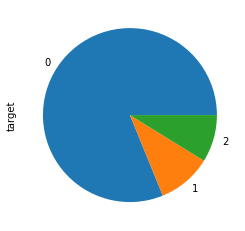

In [98]:
counts_df = twitter_df['target'].value_counts(1).to_frame().reset_index()
counts_df['target'].plot.pie()

In [99]:
# twitter_df['target'].value_counts(1).to_frame

In [100]:
import plotly.express as px
from plotly.subplots import make_subplots

# pfig = make_subplots(cols=1)
pfig = px.histogram(twitter_df,x='delta_price',color='target')
pfig.show()


In [101]:
twitter_df.to_csv('data/trump_tweets_plus_target.csv')

# Delta Stock Price Classification Models

## FINAL STOCK DATASET ADJUSTMENTS

In [102]:
## SETTINGS FOR WHICH TAREGET COLUMNS TO USE AND WHETHER TO USE BINARY OR MULTI CLASS
TARGET_COL = 'price_bins' # Options= 'delta_price','multi'
CLASS_TYPE = 'multi'


if CLASS_TYPE == 'binary':
    target_map = {'decrease':0,'increase':1}
else:
    target_map = {'decrease':0,'no change':1,'increase':2}

## Make Reverse Lookup Dict
target_map_lookup = {v:k for k,v in target_map.items()}
target_map_lookup

{0: 'decrease', 1: 'no change', 2: 'increase'}

In [103]:
## Map TARGET_COL to target
twitter_df['target'] = twitter_df[TARGET_COL].map(target_map)
twitter_df['target'].value_counts(1,dropna=False)

1    0.811719
0    0.100333
2    0.087949
Name: target, dtype: float64

> Use the below cell to reduce to binary classifcation and/or to slice specific time periods

## Setting modeling task by creating `data_df`

In [104]:
## CREATE data_df
data_df = twitter_df.loc[:'2019']
# data_df = twitter_df.loc[twitter_df[TARGET_COL]!='no change']
data_df

,date,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date-corrected,,,,,,,,,,,,,,,,,
2009-09-29 11:28:23,2009-09-29 15:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73,39.67,-0.06,no change,no change,1,no change
2009-10-05 10:37:38,2009-10-05 14:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56,38.57,0.01,no change,no change,1,no change
2009-10-14 10:13:17,2009-10-14 14:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46,40.51,0.05,no change,no change,1,no change
2009-10-27 11:31:48,2009-10-27 15:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26,39.19,-0.07,no change,no change,1,no change
2009-11-02 10:57:56,2009-11-02 14:57:56,5364614040,"--Work has begun, ahead of schedule, to build ...",f,f,Twitter Web Client,12,12,2009-11-02 11:58:00,2009-11-02 10:58:00,38.49,38.50,0.01,no change,no change,1,no change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27 12:37:20,2019-12-27 16:37:20,1210600560719781889,Thank YOU Indian Country for being such an IMP...,f,f,Twitter for iPhone,93788,19403,2019-12-27 13:38:00,2019-12-27 12:38:00,127.47,127.46,-0.01,no change,no change,1,no change
2019-12-31 10:06:09,2019-12-31 14:06:09,1212012065440894976,President Putin of Russia called to thank me a...,f,f,Twitter for iPhone,132152,25991,2019-12-31 11:07:00,2019-12-31 10:07:00,126.88,126.68,-0.20,decrease,no change,1,decrease
2019-12-31 10:16:40,2019-12-31 14:16:40,1212014713808273410,I will be signing our very large and comprehen...,f,f,Twitter for iPhone,88417,20283,2019-12-31 11:17:00,2019-12-31 10:17:00,126.94,126.65,-0.29,decrease,decrease,0,decrease


In [105]:
data_df[TARGET_COL].value_counts()

no change    6360
decrease      573
increase      455
Name: price_bins, dtype: int64

In [106]:
data_df['target'].value_counts(1)

1    0.860855
0    0.077558
2    0.061586
Name: target, dtype: float64

### NOTE ON VARS TO USE

> - For all modeling below, use the following variables for generating X and y data:
    - dataframe = `data_df` # made from twitter_df
    - target column = `'target'` # made from `TARGET_COL`
    - text column = `'text'`
- e.g.
    - `X = data_df['text'].copy()`
    - `y = data_df['target'].copy()`

## sklearn

In [107]:
from sklearn.preprocessing import LabelEncoder
## Train Test Split

X = data_df['text'].copy()
y = data_df['target']#.map({'decrease':0,'no change':1,'increase':2})

y.value_counts(dropna=False,normalize=True)

1    0.860855
0    0.077558
2    0.061586
Name: target, dtype: float64

In [108]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,random_state=42)
X_train.shape

(5541,)

## Class Imbalance

In [109]:
y_train.value_counts(1)

1    0.861036
0    0.075438
2    0.063526
Name: target, dtype: float64

In [110]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),weights))
weights

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning:

Pass classes=[0 1 2], y=date-corrected
2013-02-07 10:50:47    1
2018-09-26 13:31:40    1
2017-02-16 10:10:49    0
2019-11-07 11:18:53    1
2013-02-27 13:18:06    1
                      ..
2016-08-10 13:54:53    1
2016-09-12 11:51:45    1
2017-01-06 10:18:51    1
2012-10-05 14:39:04    1
2019-12-16 10:40:22    1
Name: target, Length: 5541, dtype: category
Categories (3, int64): [0 < 1 < 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error



{0: 4.41866028708134, 1: 0.387130580591071, 2: 5.247159090909091}

In [111]:
X_train

date-corrected
2013-02-07 10:50:47    Democrats try so hard to mock &amp, belittle R...
2018-09-26 13:31:40    RT @PeteHegseth: This @realDonaldTrump speech ...
2017-02-16 10:10:49    "FAKE NEWS media, which makes up stories and "...
2019-11-07 11:18:53             THANK YOU! #MAGA https://t.co/e6dZshYFMV
2013-02-27 13:18:06    .....Guy in front asked for picture- said he w...
                                             ...                        
2016-08-10 13:54:53    I will be interviewed on @greta tonight at 7pm...
2016-09-12 11:51:45    Stopped by @TrumpDC to thank all of the tremen...
2017-01-06 10:18:51    Anna Wintour came to my office at Trump Tower ...
2012-10-05 14:39:04    Now America knows--the Emperor has no clothes....
2019-12-16 10:40:22    RT @real_defender: @realDonaldTrump Republican...
Name: text, Length: 5541, dtype: object

In [112]:
import nltk,string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
stopwords_list = stopwords.words('english')
stopwords_list+=string.punctuation

In [113]:
tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False)

## Make TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=False,tokenizer=tokenizer.tokenize,
                            stop_words=stopwords_list)
# vectorizer.fit_transform(X_train)

In [116]:
# Make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf

<5541x13762 sparse matrix of type '<class 'numpy.float64'>'
	with 63015 stored elements in Compressed Sparse Row format>

In [122]:
target_map.keys()

dict_keys(['decrease', 'no change', 'increase'])

In [123]:
from sklearn import metrics
import matplotlib.pyplot as plt
# my_scorer = metrics.make_scorer(evaluate_model,)

def evaluate_model(y_test,y_hat_test,X_test,clf=None,
                  scoring=metrics.recall_score,verbose=False,
                  scorer=False,classes=target_map.keys()):
    
    if classes is None:
        if len(np.unique(y_test))==3:
            
            classes=['Decrease','No Change', 'Increase']
        else:
            classes = ['Decrease', 'Increase']
        

    print(metrics.classification_report(y_test,y_hat_test,
                                        target_names=classes))
    
    metrics.plot_confusion_matrix(clf,X_test,y_test,normalize='true',
                                 cmap='Blues',display_labels=classes)
    plt.show()
    if verbose:
        print("MODEL PARAMETERS:")
        print(pd.Series(rf.get_params()))
        
    if scorer:
        
        return scoring(y_test,y_hat_test)
    

### DummyClassifier

              precision    recall  f1-score   support

    decrease       0.09      0.08      0.08       155
   no change       0.86      0.87      0.87      1589
    increase       0.02      0.02      0.02       103

    accuracy                           0.76      1847
   macro avg       0.32      0.32      0.32      1847
weighted avg       0.75      0.76      0.75      1847



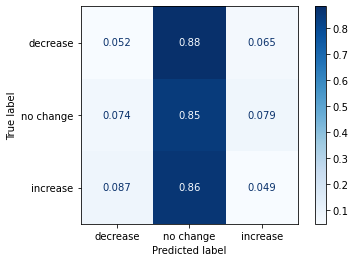

In [126]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train_tfidf,y_train)

## Get predictions
y_hat_test = dummy.predict(X_test_tfidf)
y_hat_train = dummy.predict(X_train_tfidf)
evaluate_model(y_test,y_hat_test,X_test_tfidf,dummy)

### RandomForest

              precision    recall  f1-score   support

    decrease       0.00      0.00      0.00       155
   no change       0.86      1.00      0.92      1589
    increase       0.17      0.01      0.02       103

    accuracy                           0.86      1847
   macro avg       0.34      0.34      0.31      1847
weighted avg       0.75      0.86      0.80      1847



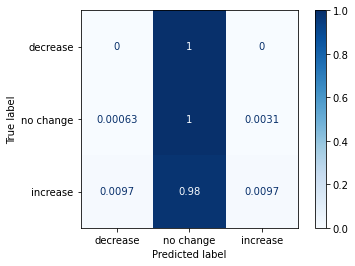

In [134]:
from sklearn.ensemble import RandomForestClassifier
## Make and fit a random forest
rf = RandomForestClassifier(class_weight= 'balanced')
rf.fit(X_train_tfidf,y_train)

## Get predictions
y_hat_test = rf.predict(X_test_tfidf)
y_hat_train = rf.predict(X_train_tfidf)

## Evaluate MOdel
evaluate_model(y_test,y_hat_test,X_test_tfidf,rf)

### GridSearch RF

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

tokenizer = nltk.TweetTokenizer(preserve_case=False)
vectorizer = TfidfVectorizer()#tokenizer=tokenizer.tokenize,
#                             stop_words=stopwords_list)
rf_pipe = Pipeline(steps=[
    ('vectorizer',vectorizer),
    ('rf',RandomForestClassifier(class_weight='balanced'))
])
rf_pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('rf', RandomForestClassifier(class_weight='balanced'))])

In [129]:
params = {'vectorizer__tokenizer':[None,tokenizer.tokenize],
         'vectorizer__stop_words':[None,stopwords_list],
         'vectorizer__use_idf':[True,False],
          'vectorizer__smooth_idf':[True,False]}

grid = GridSearchCV(rf_pipe, params,cv=3,n_jobs=-1)#,scoring='recall_macro')
grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'vectorizer__smooth_idf': [True, False],
                         'vectorizer__stop_words': [None,
                                                    ['i', 'me', 'my', 'myself',
                                                     'we', 'our', 'ours',
                                                     'ourselves', 'you',
                                                     "you're", "you've",
                                                     "you'll", "you'd", 'your',
                                                     'yours', 'yourself',
                                                     'yourselves', 'he', 'him',
                                                     'his', 'himself', 'she',
         

In [130]:
grid.fit(X_train,y_train)
grid.best_params_

{'vectorizer__smooth_idf': False,
 'vectorizer__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',

In [131]:
target_map

{'decrease': 0, 'no change': 1, 'increase': 2}

In [132]:
# trump_classes = ['Not Trump','Trump']

              precision    recall  f1-score   support

    decrease       0.00      0.00      0.00       155
   no change       0.86      1.00      0.92      1589
    increase       0.20      0.01      0.02       103

    accuracy                           0.86      1847
   macro avg       0.35      0.34      0.31      1847
weighted avg       0.75      0.86      0.80      1847



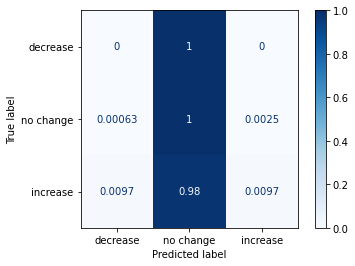

In [133]:
best_pipe = grid.best_estimator_
y_hat_test = best_pipe.predict(X_test)
evaluate_model(y_test,y_hat_test,X_test,best_pipe)

# Explaining NLP With Lime

- Easy to use with sklearn models:
    - https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b
    - https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b
    - [Lime TextClassification Tutorial](https://marcotcr.github.io/lime/tutorials/Lime%20-%20multiclass.html)


- Some hoops to jump through for ANNs:
    - https://data4thought.com/deep-lime.html

In [ ]:
# !pip install -U lime
import lime 
from lime import lime_text

In [ ]:
class_map = {0:'Not Trump',1:'Trump'}

In [ ]:
i = np.random.choice(range(len(y_train)))
print(f'For row {i}, Actual Class =',class_map[y_train[i]])
print(X_train[i])

In [ ]:
i = np.random.choice(range(len(y_train)))
print('Actual Class =',y_train[i])
explainer = lime_text.LimeTextExplainer(class_names=['Staffer','Trump'])
exp = explainer.explain_instance(X_train[i], best_pipe.predict_proba, labels=[ 1])

exp.show_in_notebook(text=True)

In [ ]:
help(exp)

### Naive Bayes

In [ ]:
def fit_evaluate_model(model,X_train,y_train,X_test):
    model.fit(X_train,y_train)

    ## Get predictions
    y_hat_test = model.predict(X_test)

    ## Evaluate MOdel
    evaluate_model(y_test,y_hat_test,X_test,model)
    return model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
bayes = fit_evaluate_model(MultinomialNB(),X_train_tfidf,y_train,X_test_tfidf)

## Neural Networks

In [135]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical

text_data = data_df['text']#.tolist()

# Changed for class imblanace  #
if data_df['target'].nunique()>2:
    y = to_categorical(data_df['target'])#,num_classes=3)
else:
    y = data_df['target'].values
print(f'y.shape={y.shape}')

y.shape=(7388, 3)


In [136]:
tokenizer = Tokenizer()

## FIGURE OUT WHICH VERSION TO USE WITH SERIES:
tokenizer.fit_on_texts(text_data)

In [137]:
# return integer-encoded sentences
X = tokenizer.texts_to_sequences(text_data)
[len(x) for x in X[:10]]

[23, 20, 18, 20, 18, 23, 19, 13, 21, 26]

In [138]:
X = sequence.pad_sequences(X)
X.shape

(7388, 58)

In [139]:
MAX_SEQUENCE_LENGTH = X.shape[1]
print(f'Sequence length: {MAX_SEQUENCE_LENGTH}')

## Save word indices
word_index = tokenizer.index_word
reverse_index = {v:k for k,v in word_index.items()}

Sequence length: 58


In [140]:
word_index[1]#.keys()

'the'

In [141]:
reverse_index['republican']

198

In [147]:
## Train test split
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.15,random_state=321)#, val_size=0.15)
y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [149]:
def get_class_balances(y_train, y_test,show_styler=False):
    if y_train.ndim >1:
        ## Final Class Balance Check
        class_balance = pd.DataFrame({'y_train':pd.Series(y_train.argmax(1)).value_counts(1),
                      'y_test':pd.Series(y_test.argmax(1)).value_counts(1)})#,index=classes)

    else:
        class_balance = pd.DataFrame({'y_train':pd.Series(y_train).value_counts(1),
                  'y_test':pd.Series(y_test).value_counts(1)})#,index=classes)

    # class_balance.index=classes
    class_balance.index = class_balance.index.map(target_map_lookup)
    if show_styler:
        display(class_balance.style.background_gradient())

#     else:
    return class_balance
    
class_balance = get_class_balances(y_train,y_test,1)
class_balance.reset_index(inplace=True)

,y_train,y_test
no change,0.862239,0.853021
decrease,0.076605,0.082958
increase,0.061156,0.064022


In [151]:
# from sklearn.utils.class_weight import compute_class_weight
# weights = compute_class_weight('balanced',np.unique(y_train),y_train)
# weights = dict(zip(np.unique(y_train),weights))
# weights

In [152]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',
                               np.unique(y_train.argmax(1)),
                               y_train.argmax(1))
weights = dict(zip(np.unique(y_train.argmax(1)),weights))
weights

{0: 4.351351351351352, 1: 0.3865903213889915, 2: 5.450520833333333}

In [153]:
# if y_train.ndim >1:
#     ## Final Class Balance Check
#     class_balance = pd.DataFrame({'y_train':pd.Series(y_train.argmax(1)).value_counts(1),
#                   'y_test':pd.Series(y_test.argmax(1)).value_counts(1)})#,index=classes)
    
# else:
#     class_balance = pd.DataFrame({'y_train':pd.Series(y_train).value_counts(1),
#               'y_test':pd.Series(y_test).value_counts(1)})#,index=classes)
# # class_balance.index=classes
# class_balance.index = class_balance.index.map(target_map_lookup)
# display(class_balance.style.background_gradient())

### Reference
https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [154]:
class_balance['y_train'].max()

0.862239210065297

In [155]:
from tensorflow.keras import callbacks, models, layers, optimizers, regularizers

## EarlyStopping Callback
earlystopping = callbacks.EarlyStopping( monitor='val_loss',
#     min_delta=class_balance['y_train'].max(),
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,)

In [156]:
## Calc classes by ndim
n_classes = y_train.ndim
n_classes

2

In [157]:
len(target_map_lookup)

3

In [158]:
def evaluate_network(y_true,X_test,model,binary=True,
                     classes=['Not Trump','Trump']):#target_map.keys()):
    
    ## Get Predictions 
    y_pred = model.predict(X_test)
    
    ## Make sure y data is sklearn compatible
    if y_true.ndim>1:
        y_test = y_true.argmax(1)
    else:
        y_test = y_true#.round()
        
    if binary:
        y_hat_test = y_pred.flatten().round()    
    else:
        y_hat_test = y_pred.argmax(1)
        
    
    ## Print Classification Report
    print(metrics.classification_report(y_test,y_hat_test))


    ## Get Normalzied Confusion Matrix
    cm = metrics.confusion_matrix(y_test,y_hat_test,normalize='true')

    ## Make Conf Matr Df To Display
    cm_df =pd.DataFrame(cm,index=classes,columns=classes)
    
    sns.heatmap(cm_df,annot=True,cmap='Blues')
#     display(cm_df.style.background_gradient(axis=1).set_caption('Normalized Confusion Matrix'))


In [159]:
## Make model infrastructure:
model0 = models.Sequential()

## Get and add embedding_layer
model0.add(layers.Embedding(input_dim=len(tokenizer.word_index)+1,
                            input_length=MAX_SEQUENCE_LENGTH,output_dim=100))

# model0.add(layers.SpatialDropout1D(0.2))
model0.add(layers.LSTM(units=50))#, dropout=0.5,recurrent_dropout=0.3,
#                        kernel_regularizer=regularizers.l2(.1)))

##Save n_classes to programmatically change the final layer and loss functions
y_dim = y_train.ndim

if y_dim>1:
    act_func = 'softmax'
    loss_func = 'categorical_crossentropy'
    n_classes = len(target_map_lookup)

else:
    act_func = 'sigmoid'
    loss_func = 'binary_crossentropy'
    n_classes = 1
    
## Add Final Layers and Compile    
model0.add(layers.Dense(n_classes,activation=act_func))#3

model0.compile(loss=loss_func,optimizer="rmsprop",metrics=['acc']) #optimizer="rmsprop"

## Display summary and parans set using n_classes
display(model0.summary())
print(f"Final Layer Act Func= {act_func}; Loss Func= {loss_func}\n\n")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 58, 100)           1678100   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 1,708,453
Trainable params: 1,708,453
Non-trainable params: 0
_________________________________________________________________


None

Final Layer Act Func= softmax; Loss Func= categorical_crossentropy




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 58, 100)           1678100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 1,738,803
Trainable params: 1,738,803
Non-trainable params: 0
_________________________________________________________________


None

Final Layer Act Func= softmax; Loss Func= categorical_crossentropy


Epoch 1/10
157/157 [==============================] - 15s 72ms/step - loss: 12.6186 - acc: 0.4006 - val_loss: 1.0944 - val_acc: 0.0478
Epoch 2/10
157/157 [==============================] - 11s 69ms/step - loss: 1.1398 - acc: 0.1422 - val_loss: 1.0627 - val_acc: 0.8750
Epoch 3/10
157/157 [==============================] - 11s 72ms/step - loss: 1.0935 - acc: 0.5543 - val_loss: 1.1276 - val_acc: 0.0478
Epoch 4/10
157/157 [==============================] - 11s 71ms/step - loss: 1.0807 - acc: 0.4958 - val_loss: 1.1595 - val_acc: 0.0955
Epoch 5/10
157/157 [==============================] - 11s 73ms/step - loss: 1.1254 - acc: 0.4594 - val_loss: 1.0178 - val_acc: 0.6083
Epoch 6/10
157/157 [==============================] - 14s 87ms/step - loss: 1.0810 - acc: 0.5684 - val_loss: 1.1127 - val_acc: 0.4610
Epoch 7/10
157/157 [==============================] - 16s 99ms/step - loss: 1.0763 - acc: 0.5786 - val_loss: 1.0745 - val_acc:

<Figure size 432x288 with 0 Axes>

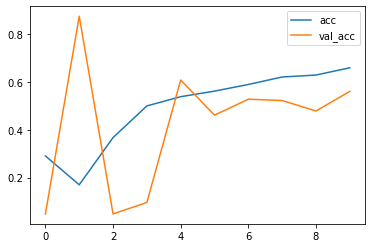

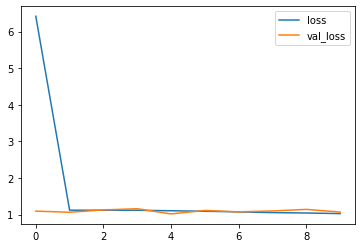

<Figure size 432x288 with 0 Axes>

In [162]:
## Make model infrastructure:
model0 = models.Sequential()

## Get and add embedding_layer
model0.add(layers.Embedding(input_dim=len(tokenizer.word_index)+1,
                            input_length=MAX_SEQUENCE_LENGTH,output_dim=100))

# model0.add(layers.SpatialDropout1D(0.2))
model0.add(layers.Bidirectional(layers.LSTM(units=50, dropout=0.5,recurrent_dropout=0.3,
                       kernel_regularizer=regularizers.l2(.1))))

##Save n_classes to programmatically change the final layer and loss functions
y_dim = y_train.ndim

if y_dim>1:
    act_func = 'softmax'
    loss_func = 'categorical_crossentropy'
    n_classes = len(target_map_lookup)

else:
    act_func = 'sigmoid'
    loss_func = 'binary_crossentropy'
    n_classes = 1
    
## Add Final Layers and Compile    
model0.add(layers.Dense(n_classes,activation=act_func))#3

model0.compile(loss=loss_func,optimizer="rmsprop",metrics=['acc']) #optimizer="rmsprop"

## Display summary and parans set using n_classes
display(model0.summary())
print(f"Final Layer Act Func= {act_func}; Loss Func= {loss_func}\n\n")

## Fit Model and Visualize History
history = model0.fit(X_train,y_train,batch_size=32,
                     epochs=10,validation_split=0.2,
                     class_weight=weights,
                    callbacks=[earlystopping])

res_df = pd.DataFrame(history.history)#.plot()
res_df[[c for c in res_df.columns if 'acc' in c]].plot()
res_df[[c for c in res_df.columns if 'loss' in c]].plot()
plt.figure()

In [163]:
evaluate_network(y_test,X_test,model0,binary=True)

ValueError: Found input variables with inconsistent numbers of samples: [1109, 3327]

In [ ]:
## Make model infrastructure:
model1 = models.Sequential()

## Get and add embedding_layer
model1.add(layers.Embedding(input_dim=len(tokenizer.word_index)+1,
                            input_length=MAX_SEQUENCE_LENGTH,output_dim=100))
model1.add(layers.SpatialDropout1D(0.2))
model1.add(layers.LSTM(units=50, dropout=0.5,recurrent_dropout=0.3,return_sequences=True,
                       kernel_regularizer=regularizers.l2(.1)))
# model0.add(layers.SpatialDropout1D(0.2))
model1.add(layers.LSTM(units=50, dropout=0.5,recurrent_dropout=0.3,return_sequences=False))#,
#                        kernel_regularizer=regularizers.l2(.1)))
# model0_wv.add(layers.Bidirectional(layers.LSTM(units=100, return_sequences=True,
#                        dropout=0.5,recurrent_dropout=0.2,
# #                        kernel_regularizer=regularizers.l2(.01))))
# model0.add(layers.Bidirectional(layers.LSTM(units=100, return_sequences=False,
#                        dropout=0.3,recurrent_dropout=0.2,
#                        kernel_regularizer=regularizers.l2(.01))))

##Save n_classes to programmatically change the final layer and loss functions
y_dim = y_train.ndim

if y_dim>1:
    act_func = 'softmax'
    loss_func = 'categorical_crossentropy'
    n_classes = len(target_map_lookup)

else:
    act_func = 'sigmoid'
    loss_func = 'binary_crossentropy'
    n_classes = 1
    
## Add Final Layers and Compile    
model1.add(layers.Dense(n_classes,activation=act_func))#3

model1.compile(loss=loss_func,optimizer="rmsprop",metrics=['acc']) #optimizer="rmsprop"

## Display summary and parans set using n_classes
display(model1.summary())
print(f"Final Layer Act Func= {act_func}; Loss Func= {loss_func}\n\n")

## Fit Model and Visualize History
history = model1.fit(X_train,y_train,batch_size=32,
                     epochs=10,validation_split=0.2,
                     class_weight=weights,
                    callbacks=[earlystopping])

res_df = pd.DataFrame(history.history)#.plot()
res_df[[c for c in res_df.columns if 'acc' in c]].plot()
res_df[[c for c in res_df.columns if 'loss' in c]].plot()

In [ ]:
evaluate_network(y_test,X_test,model1,binary=True)

# BOOKMARK - ADDING FUNCTIONS FROM `My Copy of Using Colab for Computer Vision/Intro to CNNs.ipynb'
- https://colab.research.google.com/drive/1EPkMTkP1vkO4GfUMVfSd_FH7Tnl1-Jf8?usp=sharing

In [ ]:
def plot_history(history, metric_list=['loss','acc']):
    """Plots keras training history"""
    ## Get History  as adf
    history_df = pd.DataFrame(history.history)
    ## PLotn all fo the metrics in history
   
    for metric in metric_list:
        history_df[[col for col in history_df.columns if metric in col]].plot(
        marker='o',ls=':')
        
    plt.suptitle('Training History')
    plt.show()

    return plt.gcf()


def make_fit_plot_model(build_fn,X_train,y_train,X_val,y_val,training_set=None,
                        validation_split=None, 
                        epochs=5,fit_kws={},binary=True,evaluate=True):
    """Builds, fits, and (optionally) evaluate a neural network created
    from the build_fn"""

    ## Print Start Time
    start = dt.datetime.now(tz=get_localzone())
    fmt= "%m/%d/%y - %T %p"

    print('---'*20)    
    print(f'[i] MODEL CREATED AT {start.strftime(fmt)}')
    print('---'*20)
    print()
    
    ## Use new functions to make model and plot history
    model = build_fn()

    ## Use training_set if provided
    if training_set is not None:

        if validation_split is not None:
            history = model.fit(training_set, epochs=epochs,**fit_kws,
                                validation_split=validation_split)
        else:
            history = model.fit(training_set, epochs=epochs,**fit_kws,
                            validation_data=(X_val,y_val))
    
    else:
        if validation_split is not None:
            history = model.fit(X_train,y_train, epochs=epochs,**fit_kws,
                                validation_split=validation_split)
        else:
            history = model.fit(X_train,y_train, epochs=epochs,**fit_kws,
                            validation_data=(X_val,y_val))
    
    ## Print Total Time
    end = dt.datetime.now(tz=get_localzone())
    print(f'\n[!] Training Completed AT {end.strftime(fmt)}')
    # print()
    print(f"\n[i] Total Training Time: {end-start}")

    if evaluate:
        evaluate_model(model,history,X_test,y_test,binary=binary)

    return model,history
    

## Making a function for just evaluting not fitting
def evaluate_model(model,history,X_test,y_test,binary=True):

    ## Get Model history and plot
    # history = model.history
    try:
        plot_history(history)
    except:
        pass
    
    ## Get predictions
    y_hat_test = model.predict(X_test)

    if binary:
        y_hat_test = y_hat_test.round()
    else:
        y_hat_test = y_hat_test.argmax(axis=1)


    ## Print classification report
    print('---'*20)  
    print('---'*20)  
    print('[i] Classification Report')
    print(metrics.classification_report(y_test,y_hat_test))
    print('---'*20)  


    ## Get and PLot the confusion matrix
    cm = metrics.confusion_matrix(y_test, y_hat_test,
                                normalize='true')

    ax = sns.heatmap(cm, cmap='Blues',annot=True,square=True)
    ax.set(xlabel='Predicted Class',ylabel='True Class')

# TO DO/ FUTURE WORK

In [ ]:
stop

## UPDATING ANN WORKFLOW TO USE  LIME TextExplainer


- LIME WITH NEURAL NETWORKS:
    - https://data4thought.com/deep-lime.html

### Making Workflow sklearn compatible

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin, make_pipeline,Pipeline
from sklearn.base import BaseEstimator

In [ ]:
class TextsToSequences(Tokenizer, BaseEstimator,TransformerMixin):
    """Modified Source Code from https://data4thought.com/deep-lime.html"""
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def fit(self,texts,y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
    
    
sequencer = TextsToSequences(num_words=2000)
sequencer

## Lime- sklearn Models

In [ ]:
# !pip install -U lime
import lime 
from lime import lime_text

In [ ]:
i = np.random.choice(range(len(y_train)))
i_txt = X_train[i]
i_label = y_train[i]
i_txt

In [ ]:
tokenizer.sequences_to_texts([i_txt])

In [ ]:
explainer = lime_text.LimeTextExplainer(class_names=['Not Trump','Trump'])
exp = explainer.explain_instance()

## NEXT: USE GLOVE TWITTER EMBEDDINGS

In [ ]:
stop

In [ ]:
glove = '/Users/jamesirving/Datasets/glove.twitter.27B/'
os.listdir(glove)

In [ ]:
# embedding_file = glove+'glove.twitter.27B.100d.txt'
# embedding_file

In [ ]:
## Load in saved glove vectors using KeyedVectors.load_word2vec_format()
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

## Save Glove Twitter Vectors to A Glove File For Word Math
folder_for_vectors ='/Users/jamesirving/Datasets/glove.twitter.27B/'
glove_file = 'glove.twitter.27B.100d.txt'

# define full input glove and output word2vec filepaths
glove_filepath = folder_for_vectors+glove_file
w2v_filepath = folder_for_vectors+'glove_to_w2vec.txt'

glove2word2vec(glove_filepath,w2v_filepath)
glovew2v_model = KeyedVectors.load_word2vec_format(w2v_filepath)
wvg = glovew2v_model.wv

In [ ]:
help(wvg)

In [ ]:
## Getting embedding layer directly from wvg
glove_embedding = wvg.get_keras_embedding()
help(glove_embedding)

In [ ]:
## Make model infrastructure:
model1 = models.Sequential()

## Get and add embedding_layer
model1.add(wvg.get_keras_embedding())
model1.add(layers.SpatialDropout1D(0.2))
model1.add(layers.LSTM(units=50, dropout=0.5,recurrent_dropout=0.3,return_sequences=True,
                       kernel_regularizer=regularizers.l2(.1)))
# model0.add(layers.SpatialDropout1D(0.2))
model1.add(layers.LSTM(units=50, dropout=0.5,recurrent_dropout=0.3,return_sequences=False))#,

##Save n_classes to programmatically change the final layer and loss functions
y_dim = y_train.ndim

if y_dim>1:
    act_func = 'softmax'
    loss_func = 'categorical_crossentropy'
    n_classes = len(target_map_lookup)

else:
    act_func = 'sigmoid'
    loss_func = 'binary_crossentropy'
    n_classes = 1
    
## Add Final Layers and Compile    
model1.add(layers.Dense(n_classes,activation=act_func))#3

model1.compile(loss=loss_func,optimizer="rmsprop",metrics=['acc']) #optimizer="rmsprop"

## Display summary and parans set using n_classes
display(model1.summary())
print(f"Final Layer Act Func= {act_func}; Loss Func= {loss_func}\n\n")

## Fit Model and Visualize History
history = model1.fit(X_train,y_train,batch_size=32,epochs=10,validation_split=0.2,
                    callbacks=[earlystopping])

display(evaluate_network(y_test,X_test,model1,binary=True))

res_df = pd.DataFrame(history.history)#.plot()
res_df[[c for c in res_df.columns if 'acc' in c]].plot()
res_df[[c for c in res_df.columns if 'loss' in c]].plot()

# APPENDIX

### Testing code to make evalute_network

In [ ]:
# y_true = y_test
# binary=True

# ## Get Predictions and Classification Report
# y_pred = model0.predict(X_test)
# y_true.shape, y_pred.shape

In [ ]:
# ## Make sure y data is sklearn compatible
# if y_true.ndim>1:
#     y_true = y_true.argmax(1)

# # else:
# #     y_test = y_true#.round()

# if binary:
#     y_hat_test = y_pred.flatten().round()    

# else:
#     y_hat_test = y_pred.argmax(1)
    
# y_true.shape, y_hat_test.shape

In [ ]:
# print(metrics.classification_report(y_true,y_hat_test))

In [ ]:
# ## Get Normalzied Confusion Matrix
# cm = metrics.confusion_matrix(y_test.argmax(1),y_hat_test.argmax(1),normalize='true')
# classes = ['Decrease','Increase']

# ## Make Conf Matr Df To Display
# cm_df =pd.DataFrame(cm,index=classes,columns=classes)
# cm_df.style.background_gradient(axis=1)

## Other Networks

In [ ]:
stop

In [ ]:
## GRU Model
from tensorflow.keras import models, layers, optimizers, regularizers
model0B = models.Sequential()

## Get and add embedding_layer
# embedding_layer = ji.make_keras_embedding_layer(wv, X_train)
model0B.add(wvg.get_keras_embedding())

model0B.add(layers.SpatialDropout1D(0.5))
model0B.add(layers.Bidirectional(layers.GRU(units=100, dropout=0.5, recurrent_dropout=0.2,return_sequences=True)))
model0B.add(layers.Bidirectional(layers.GRU(units=100, dropout=0.5, recurrent_dropout=0.2)))
model0B.add(layers.Dense(3, activation='softmax'))

model0B.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['acc'])#,'val_acc'])#, callbacks=callbacks)
model0B.summary()

# REMOVED FINDING TRUMP

In [ ]:
STOCK_FILES[file] = pd.to_datetime(time.ctime(os.path.getmtime(file)))